# Part 1

In [3]:
import pandas as pd

mdf = pd.read_csv('linked_mortality_file_1999_2000.csv') # Load mortality file
#print( mdf.head() )
gdf = pd.read_sas("DEMO.xpt", format="xport") # Load demographics file
#print( gdf.head() )
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable

drug = pd.read_sas("DUQ.xpt", format="xport") # Load drug file
drugdf = drug.merge(df, on="SEQN", how="inner") # Merge drug and demographics/mortality on SEQN variable
print( drugdf.head() )


   SEQN  DUQ100        DUQ110  DUQ120  DUQ130  SDDSRVYR  RIDSTATR  RIDEXMON  \
0   5.0     2.0           NaN     NaN     NaN       1.0       2.0       2.0   
1   7.0     2.0           NaN     NaN     NaN       1.0       2.0       2.0   
2  10.0     2.0           NaN     NaN     NaN       1.0       2.0       2.0   
3  12.0     1.0  5.397605e-79     2.0     NaN       1.0       2.0       1.0   
4  15.0     2.0           NaN     NaN     NaN       1.0       2.0       1.0   

   RIAGENDR  RIDAGEYR  ...       WTIREP50       WTIREP51       WTIREP52  \
0       1.0      49.0  ...   92817.926915   94282.855382   91993.251203   
1       2.0      59.0  ...   22807.008623   23085.785591   23918.402495   
2       1.0      43.0  ...   21725.159674   21625.081706   22539.031224   
3       1.0      37.0  ...   94400.394199   95890.298459   93561.658462   
4       2.0      38.0  ...  110186.143135  112750.496899  110008.647960   

   ELIGSTAT  MORTSTAT  UCOD_LEADING  DIABETES  HYPERTEN  PERMTH_INT  \
0  

Variables Explained:

`ELIGSTAT`: Indicates eligibility status for mortality follow-up. A value of 1 indicates that the participant was eligible for mortality linkage. A value of 2 indicates that the participant was under 18 and not eligible for public release. A value of 3 indicates they were not linkage eligible due to insufficient identifying data to conduct data linkage. 

`MORTSTAT`: Indicates the determination of vital status. Each participant who is linkage eligible for mortality follow-up is assigned a vital status code (0 = Assumed alive, 1 = Assumed deceased based on NDI linkage, 2 = Assumed deceased from non-NDI source).

`PERMTH_INT`: Follow-up time that has been calculated using person months from the date of the interview to the date of death or end of the mortality period.

`RIDAGEEX`: Best age in months at date of examination for individuals under 85 years of age at screening.


The dataset we selected from NHANES 1999--2000 was Drug Use (DUQ.xpt). Our rationale for selecting this dataset is that many drugs often have potentially lethal side effects. 

In [4]:
# Proportion of missing values in each column of drugdf
drugdf.isna().mean().sort_values(ascending=False)

DMAETHN     1.00000
DMDSCHOL    1.00000
DMDEDUC3    1.00000
DMARACE     1.00000
DUQ130      0.98203
             ...   
WTMREP17    0.00000
WTMREP16    0.00000
WTMREP15    0.00000
WTMREP14    0.00000
WTMREP34    0.00000
Length: 155, dtype: float64

## EDA / Visualizations

In [5]:
# Setup and variable creation
import numpy as np
import matplotlib.pyplot as plt

# Restrict to mortality-eligible respondents
df = drugdf.copy()
df = df[df["ELIGSTAT"] == 1].copy()

# Create outcome variables
df["death"] = df["MORTSTAT"].isin([1, 2]).astype(int)
df["followup_months"] = df["PERMTH_INT"]

# Clean DUQ variables (replace refused/don’t know with NaN)
duq_vars = ["DUQ100","DUQ110","DUQ120","DUQ130"]
for v in duq_vars:
    if v in df.columns:
        df[v] = df[v].replace({7: np.nan, 9: np.nan})

# Create binary indicators
df["ever_drug_use"] = (df["DUQ100"] == 1).astype(float)
df["ever_needle_use"] = (df["DUQ120"] == 1).astype(float)

print("Sample size after eligibility restriction:", len(df))

Sample size after eligibility restriction: 2835


Death distribution (proportion):
death
0    0.893474
1    0.106526
Name: proportion, dtype: float64

Follow-up time summary:
count    2835.000000
mean      229.116402
std        36.691237
min         3.000000
25%       232.000000
50%       238.000000
75%       244.000000
max       250.000000
Name: followup_months, dtype: float64


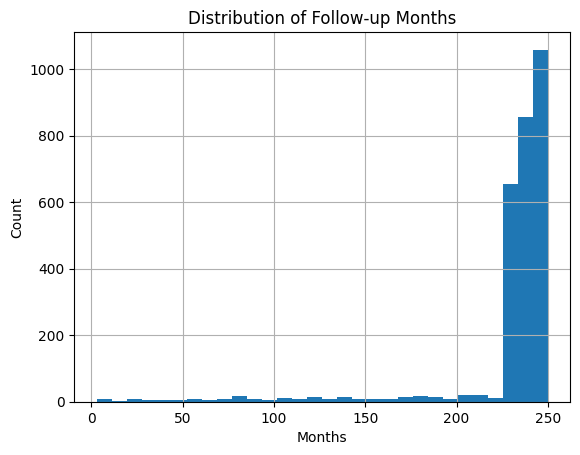

<Figure size 640x480 with 0 Axes>

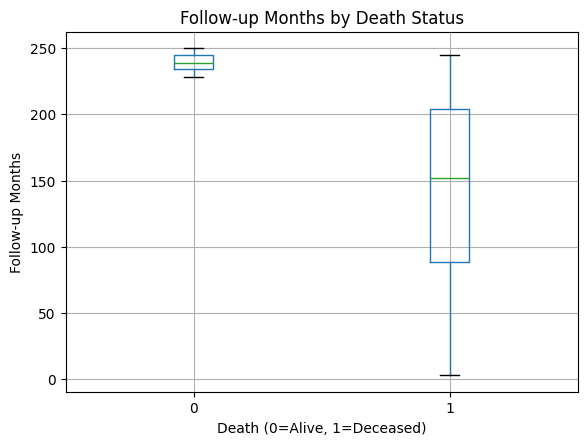

In [6]:
# Outcome Distribution (Mortality and Follow-up Time)

# Examine class balance for mortality outcome

# This shows the proportion of respondents who died (death=1) versus those still alive at end of follow-up (death=0).
# Important for understanding whether the classification problem is imbalanced.
print("Death distribution (proportion):")
print(df["death"].value_counts(normalize=True))

# Summary statistics for survival time (in months)

# Provides count, mean, median (50%), quartiles, min, and max.
print("\nFollow-up time summary:")
print(df["followup_months"].describe())

# Histogram of follow-up time

# Visualizes the distribution of survival time.
# Survival data are often right-skewed.
# Skewness may affect regression modeling choices.
plt.figure()
df["followup_months"].hist(bins=30)
plt.title("Distribution of Follow-up Months")
plt.xlabel("Months")
plt.ylabel("Count")
plt.show()

# Boxplot of follow-up time by death status

# Compares survival time between deceased and surviving respondents.
# Deceased individuals should generally show shorter follow-up times.
# This helps validate logical consistency of the mortality data.
plt.figure()
df.boxplot(column="followup_months", by="death")
plt.title("Follow-up Months by Death Status")
plt.suptitle("")  # removes automatic pandas subtitle
plt.xlabel("Death (0=Alive, 1=Deceased)")
plt.ylabel("Follow-up Months")
plt.show()

Approximately 10.7% of respondents died during the follow-up period, while 89.3% were still alive at the end of observation. This indicates a moderately imbalanced classification problem, with death as the minority outcome.

Follow-up time is concentrated near the upper end of the observation window, with a median of 238 months and a maximum of 250 months. The mean is slightly lower than the median, suggesting some early deaths pull the average downward. Overall, most individuals were followed for nearly the full period, while a smaller group experienced shorter survival times.

Lifetime Drug Use (DUQ100):
DUQ100
2.0    0.742857
1.0    0.169665
NaN    0.087478
Name: proportion, dtype: float64

Lifetime Needle Use (DUQ120):
DUQ120
NaN    0.830688
2.0    0.151323
1.0    0.017989
Name: proportion, dtype: float64

Past 12-Month Drug Use Days (DUQ110):
count    4.710000e+02
mean     1.284501e+01
std      8.298808e+01
min      5.397605e-79
25%      5.397605e-79
50%      5.397605e-79
75%      1.000000e+00
max      7.770000e+02
Name: DUQ110, dtype: float64


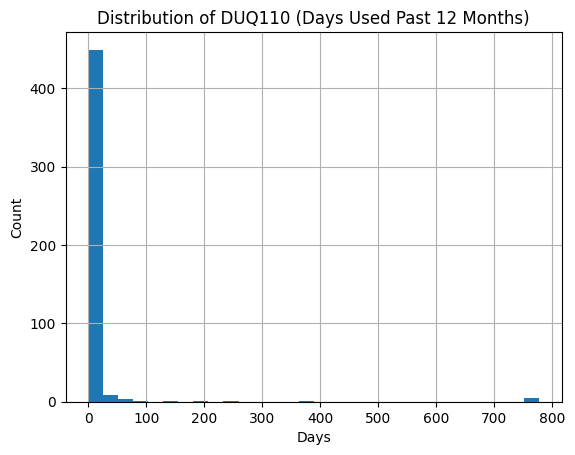

In [8]:
# Drug use distributions

# Lifetime Drug Use (DUQ100)

# Shows the proportion reporting ever using cocaine/other street drugs.
print("Lifetime Drug Use (DUQ100):")
print(df["DUQ100"].value_counts(dropna=False, normalize=True))

# Lifetime Needle Use (DUQ120)
# Typically much rarer than general drug use.
# Important to check for sparsity, which can affect modeling stability.
print("\nLifetime Needle Use (DUQ120):")
print(df["DUQ120"].value_counts(dropna=False, normalize=True))

# Past 12-Month Drug Use Days (DUQ110)

# Continuous measure of recent drug use intensity.
# Summary statistics help assess skewness and spread.
print("\nPast 12-Month Drug Use Days (DUQ110):")
print(df["DUQ110"].describe())

# Histogram of Past 12-Month Drug Use Days

# Visual check for skewness and extreme values.
plt.figure()
df["DUQ110"].dropna().hist(bins=30)
plt.title("Distribution of DUQ110 (Days Used Past 12 Months)")
plt.xlabel("Days")
plt.ylabel("Count")
plt.show()

About 17% of respondents report ever using cocaine or other street drugs, while roughly 74% report never using them. Around 9% have missing responses. This means drug use is present but not common in the sample.

Lifetime needle use is very rare. Only about 2% report ever using a needle, and most responses are missing, likely because only certain respondents were asked this question. The small number of needle users could make modeling this variable more unstable.

For past 12-month drug use days, most people report zero or very low use. The median is essentially zero, and even the 75th percentile is only 1 day. However, a few individuals report very high numbers of days, which raises the average. This shows the variable is strongly skewed, with most people reporting little use and a small group reporting heavy use.

Death rate by Lifetime Drug Use:
death          0         1
DUQ100                    
1.0     0.860707  0.139293
2.0     0.901235  0.098765

Death rate by Lifetime Needle Use:
death          0         1
DUQ120                    
1.0     0.647059  0.352941
2.0     0.885781  0.114219

Mean Past 12-Month Drug Use Days by Death Status:
death
0    12.628079
1    14.200000
Name: DUQ110, dtype: float64


<Figure size 640x480 with 0 Axes>

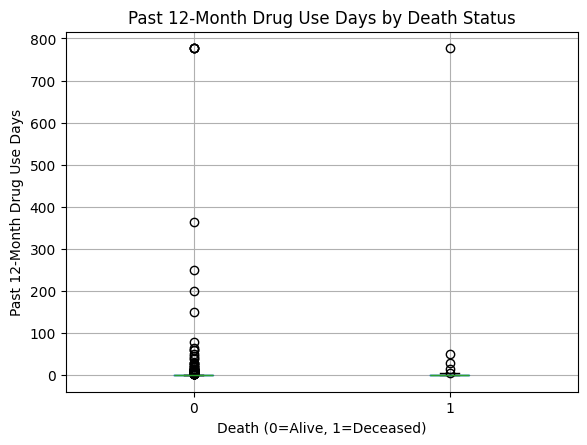

In [9]:
# Drug use and mortality relationships

# Mortality rate by Lifetime Drug Use (DUQ100)
# Contingency table showing proportion deceased within each lifetime drug-use group.
# Helps assess whether ever using drugs is associated with higher observed mortality.
print("Death rate by Lifetime Drug Use:")
print(pd.crosstab(df["DUQ100"], df["death"], normalize="index"))

# Mortality rate by Lifetime Needle Use (DUQ120)

# Same structure as above, but for needle use.
# Because needle use is rare, check whether mortality
# rates differ substantially between groups.
print("\nDeath rate by Lifetime Needle Use:")
print(pd.crosstab(df["DUQ120"], df["death"], normalize="index"))

# Average recent drug use intensity by death status

# Compares mean number of past 12-month use days between those who died and those who survived.
# Indicates whether heavier recent use is associated with mortality.
print("\nMean Past 12-Month Drug Use Days by Death Status:")
print(df.groupby("death")["DUQ110"].mean())


# Boxplot of recent drug use days by death status

# Visual comparison of distribution of recent use intensity for deceased vs surviving respondents.
# Helps detect differences and extreme values.
plt.figure()
df.boxplot(column="DUQ110", by="death")
plt.title("Past 12-Month Drug Use Days by Death Status")
plt.suptitle("")  # removes automatic pandas subtitle
plt.xlabel("Death (0=Alive, 1=Deceased)")
plt.ylabel("Past 12-Month Drug Use Days")
plt.show()

People who have ever used cocaine or other street drugs have a slightly higher death rate (≈14%) compared with those who have never used (≈10%). This suggests a modest association between lifetime drug use and mortality.

Needle use shows a much stronger difference. About 35% of lifetime needle users died, compared with 11% of non-users. This indicates a substantial association, though the number of needle users is small.

For recent drug use (past 12 months), people who died had a slightly higher average number of use days (≈14 days) than survivors (≈13 days). Most people report very low use, so the difference is modest but consistent with the pattern seen for lifetime use.

Age summary (RIDAGEEX):
count    2826.000000
mean      461.020170
std       133.251336
min       240.000000
25%       348.000000
50%       457.000000
75%       567.000000
max       721.000000
Name: RIDAGEEX, dtype: float64


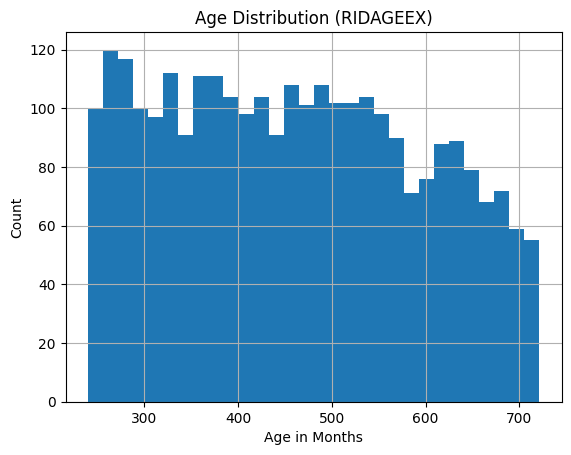


Mean Age by Death Status:
death
0    448.522754
1    566.642140
Name: RIDAGEEX, dtype: float64

Drug Use by Age Group:
DUQ100           1.0       2.0
RIDAGEEX                      
(0, 360]    0.160443  0.839557
(360, 600]  0.235947  0.764053
(600, 840]  0.087129  0.912871


In [10]:
# Age patterns 

# Summary of age (RIDAGEEX)

# Provides descriptive statistics for participant age in months.
# Age is a key confounder because it strongly influences mortality and may be associated with drug use patterns.
print("Age summary (RIDAGEEX):")
print(df["RIDAGEEX"].describe())

# Histogram of age

# Visualizes the distribution of age.
plt.figure()
df["RIDAGEEX"].hist(bins=30)
plt.title("Age Distribution (RIDAGEEX)")
plt.xlabel("Age in Months")
plt.ylabel("Count")
plt.show()

# Mean age by death status

# Compares age between deceased and surviving participants.
print("\nMean Age by Death Status:")
print(df.groupby("death")["RIDAGEEX"].mean())

# Age groups and drug use

# Creates age bins to examine patterns of drug use across age groups.
# Cross-tab shows the proportion of respondents in each age group
# who report lifetime drug use.
# This highlights potential confounding: younger participants may
# use drugs more, while older participants have higher mortality.
age_groups = pd.cut(df["RIDAGEEX"], bins=[0,360,600,840,1200])
print("\nDrug Use by Age Group:")
print(pd.crosstab(age_groups, df["DUQ100"], normalize="index"))

The participants in this dataset range in age from 240 to 721 months (20 to about 60 years), with a mean age of 461 months (≈38 years) and a median of 457 months (≈38 years). Most participants are clustered around the middle of this range.

Comparing by death status, those who died had a higher mean age (≈567 months, ~47 years) than those who survived (≈449 months, ~37 years). This confirms that older age is strongly associated with higher mortality in this sample.

Looking at drug use by age group, lifetime drug use is more common among younger participants: about 24% of the 30–50 year group reported use, compared with 16% in the youngest group (≤30) and only 9% in the oldest group (50+). This suggests that age could confound the relationship between drug use and mortality, since younger participants are more likely to use drugs, while older participants are more likely to die.

In [11]:
# PART 6: Correlation Among Continuous Variables

# Select continuous variables to examine correlations
# Includes follow-up time, recent drug use intensity, and age
cont_vars = ["followup_months","DUQ110","DUQ130","RIDAGEEX"]
cont_vars = [v for v in cont_vars if v in df.columns]

# Correlation matrix

# Computes Pearson correlation coefficients between continuous variables.

if len(cont_vars) >= 2:
    print("Correlation Matrix:")
    print(df[cont_vars].corr())

Correlation Matrix:
                 followup_months    DUQ110    DUQ130  RIDAGEEX
followup_months         1.000000  0.003477  0.102787 -0.234309
DUQ110                  0.003477  1.000000  0.966726  0.031613
DUQ130                  0.102787  0.966726  1.000000  0.002566
RIDAGEEX               -0.234309  0.031613  0.002566  1.000000


The correlation matrix shows that follow-up time is slightly negatively correlated with age (-0.23), meaning older participants tend to have shorter follow-up times, likely because they are more likely to die earlier. Recent drug use measures, DUQ110 and DUQ130, are almost perfectly correlated (0.97), which makes sense since people who report using needles recently also tend to report more days of general drug use. Follow-up time is essentially uncorrelated with recent drug use, and age shows almost no correlation with drug use, indicating that recent use is spread across ages. Overall, this suggests that the two measures of drug use are redundant, while age and follow-up time are only weakly related to drug use, so there are no major multicollinearity concerns except for the redundancy between DUQ110 and DUQ130.

Going forward, the most valuable variables for predicting mortality with KNN will be age and the key drug-use indicators. Age is strongly associated with death, with older participants more likely to die. Lifetime drug use (DUQ100) and lifetime needle use (DUQ120) also show clear differences in mortality and will help the model identify higher-risk individuals. For recent drug use, only one measure, such as DUQ110 (past 12-month use days), is needed because it is highly correlated with DUQ130, and including both would be redundant. These variables capture the strongest patterns in the data while avoiding unnecessary duplication.

# PART 2
- Q1. Each observation is a single survey participant from the 1999-2000 NHANES wave. Sicker or older participants may skip certain exams, introducing missing not at random bias that can affect kNN predictions if not handled carefully.The CDC's National Center for Health Statistics (NCHS) collects NHANES to monitor the health and nutritional status of Americans. The 1999 wave is now 25+ years old, so findings may not generalize to current populations.
- Q2. We used a k-Nearest Neighbors classifier with features including age (RIDAGEEX), lifetime drug use (DUQ100), lifetime needle use (DUQ120), and recent drug use (DUQ110).


In [69]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: C:\Users\w_mcl\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Select features for modeling
# Use age and key drug-use variables. DUQ110 is enough for recent drug use since DUQ130 is highly correlated.
features = ["RIDAGEEX", "DUQ100", "DUQ120", "DUQ110"]

# Ensure selected features exist in df
features = [f for f in features if f in df.columns]

# 2. Keep only relevant features + outcome variables
model_df = df[features + ["death", "followup_months"]].dropna()  # drop rows with missing values

# 3. Separate predictors (X) from targets
X = model_df[features]              # predictors
y_class = model_df["death"]         # classification target
y_reg = model_df["followup_months"] # regression target

# 4. Scale numeric predictors for kNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Split into train/test sets
# Classification: stratify to maintain death class proportions
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Regression: no stratification needed
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_scaled, y_reg, test_size=0.2, random_state=42
)

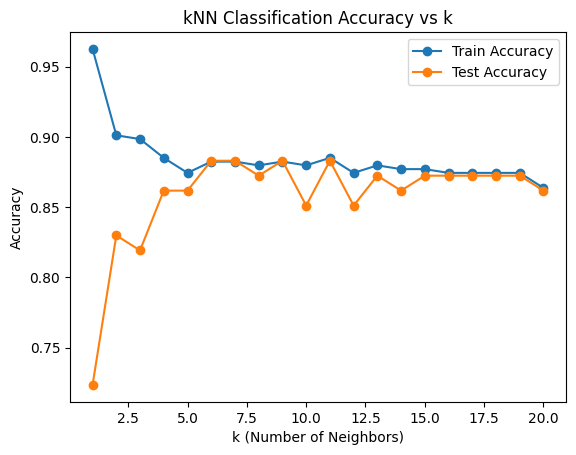

Best k for classification: 6

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.93        81
           1       0.67      0.31      0.42        13

    accuracy                           0.88        94
   macro avg       0.78      0.64      0.68        94
weighted avg       0.87      0.88      0.86        94



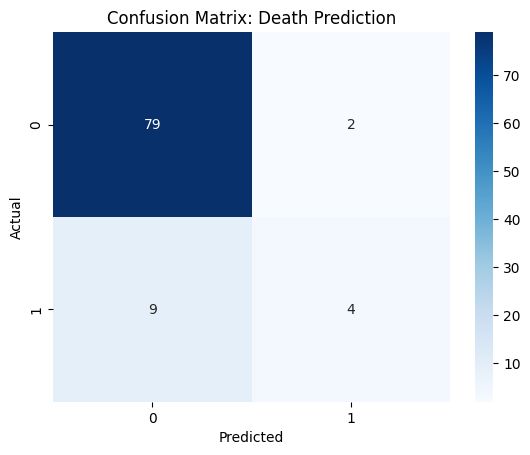

In [13]:
import sklearn
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Try different k values to find the best
k_values = list(range(1, 21))
train_acc = []
test_acc = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_class, y_train_class)
    train_acc.append(knn.score(X_train_class, y_train_class))
    test_acc.append(knn.score(X_test_class, y_test_class))

# Plot accuracy vs k
plt.figure()
plt.plot(k_values, train_acc, marker='o', label="Train Accuracy")
plt.plot(k_values, test_acc, marker='o', label="Test Accuracy")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Accuracy")
plt.title("kNN Classification Accuracy vs k")
plt.legend()
plt.show()

# Choose best k based on highest test accuracy
best_k_class = k_values[np.argmax(test_acc)]
print(f"Best k for classification: {best_k_class}")

# Train final model
knn_class = KNeighborsClassifier(n_neighbors=best_k_class)
knn_class.fit(X_train_class, y_train_class)
y_pred_class = knn_class.predict(X_test_class)

# Evaluate
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class))

# Confusion matrix
cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Death Prediction")
plt.show()

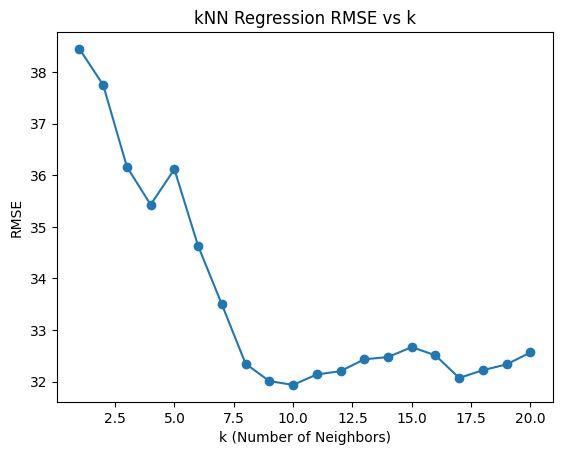

Best k for regression: 10
Regression Performance Metrics:
RMSE: 31.936261322109115
MAE: 17.286170212765956
R^2: 0.1249908324614365


In [14]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Try different k values to minimize RMSE
rmse_list = []

for k in range(1, 21):
    knn_reg = KNeighborsRegressor(n_neighbors=k)
    knn_reg.fit(X_train_reg, y_train_reg)
    y_pred = knn_reg.predict(X_test_reg)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    rmse_list.append(rmse)

# Plot RMSE vs k
plt.figure()
plt.plot(range(1, 21), rmse_list, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("RMSE")
plt.title("kNN Regression RMSE vs k")
plt.show()

# Choose best k (lowest RMSE)
best_k_reg = np.argmin(rmse_list) + 1
print(f"Best k for regression: {best_k_reg}")

# Train final regressor
knn_reg = KNeighborsRegressor(n_neighbors=best_k_reg)
knn_reg.fit(X_train_reg, y_train_reg)
y_pred_reg_final = knn_reg.predict(X_test_reg)

# Evaluate regression
print("Regression Performance Metrics:")
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_final)))
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg_final))
print("R^2:", r2_score(y_test_reg, y_pred_reg_final))


- Q3. We predicted mortality using a k-NN classifier. We tested k values from 1 to 20 neighbors and selected the k that maximized test accuracy. The best k was 6 neighbors. The classification report shows that the model predicts survivors (class 0) very well, with a precision of 0.90, recall of 0.98, and F1-score of 0.93. Predictions for deceased participants (class 1) are less accurate, with a precision of 0.67, recall of 0.31, and F1-score of 0.42. Overall accuracy is 0.88. This reflects the class imbalance in the data, where only about 10.7% of participants died during follow-up. The model is effective at identifying survivors but underestimates risk for some high-risk individuals. Age and drug-use history are clearly predictive, but rare needle use and imbalanced classes limit the classifier’s performance for the deceased group. For the kNN classifier, the accuracy curve shows that training accuracy starts very high at small k values and gradually decreases, while test accuracy rises and stabilizes around k = 6. This confirms that k = 6 is a good balance between overfitting and underfitting. 

- Q4. We predicted life expectancy using a k-NN regressor with the same features, selecting k to minimize test RMSE. The best k was 9. The k vs. RMSE plot shows error decreasing rapidly at small k, reaching a minimum at k = 9, then slightly increasing for larger k — supporting this choice as it avoids both overfitting and over-smoothing. Performance metrics are RMSE = 31.94 months, MAE = 17.53 months, and R² = 0.125. The low R² indicates the features explain only a small portion of variance in life expectancy. Most participants were observed near the full window, while a smaller group died early, compressing the predictable range. The model captures general trends — older participants and drug users tend toward shorter follow-up — but struggles with early or extreme deaths.The k vs accuracy and k vs RMSE plots provide insight into how model performance changes with the number of neighbors. The flattening of the test accuracy beyond k = 6 indicates that adding more neighbors does not meaningfully improve generalization. For the kNN regressor, the RMSE curve shows that error decreases rapidly for small k, reaches a minimum around k = 9, and then slightly increases or fluctuates for larger k values. This supports our choice of k = 9, as it minimizes prediction error on the test set while avoiding over-smoothing.

The confusion matrix for the mortality classifier illustrates the model’s strengths and weaknesses. Most survivors (class 0) are correctly predicted, with 79 out of 81 classified accurately. However, deceased participants (class 1) are frequently misclassified as survivors, with 9 out of 13 missed. Only 4 of the 13 deceased participants are correctly identified. This highlights the impact of class imbalance and the challenge of identifying rare events, which aligns with the modest recall and F1-scores for class 1 reported in the classification report. Together, the plots and confusion matrix demonstrate that the models capture general trends in mortality and follow-up time but struggle with extreme or rare outcomes.

Overall, the kNN models help identify higher-risk individuals based on age and drug-use history. They could inform targeted health interventions or monitoring programs, but limitations include class imbalance, rare exposures (needle use), and skewed survival times. Future improvements could include additional features, oversampling minority classes, or trying other machine learning models to enhance predictive performance.
